In [25]:
import torch
from torch import utils
from torch import nn
from torch.nn import functional as F
from data.torchfsdd.dataset import TorchFSDDGenerator
from data.augmentations.randphase import RandomAllPass

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt, numpy as np

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

pltr = lambda x: x.cpu().detach().numpy()

In [ ]:
import warnings
from data.augmentations.randphase import AllPassFilter
from torch_audiomentations import *
from models.pqmf import PQMF
from optim.ens_optim import HybridEnsGradOptimizer


In [ ]:
BANDS = 32
BATCH = 64

SyntaxError: invalid decimal literal (1328553766.py, line 2)

In [ ]:
# this lib spits some annoying bs so I ignore it
with warnings.catch_warnings(action="ignore"):
    # Initialize augmentation callable
    audio_augmentation = Compose(
        transforms=[
            Gain(
                min_gain_in_db=-15.0,
                max_gain_in_db=5.0,
                p=0.1,
                sample_rate = 8000,
                output_type='dict'
            ),
            AddColoredNoise(p=1,
                min_snr_in_db = 5,
                max_snr_in_db = 10,
                sample_rate = 8000),
            Shift(-0.05, 0.2, p=0.1,
                sample_rate = 8000,
                output_type='dict'),
            PolarityInversion(p=0.1,
                sample_rate = 8000,
                output_type='dict'),
            AllPassFilter(sample_rate=8000,
                output_type='dict')
        ], output_type='dict'
    )
pqmf = PQMF(100, BANDS)
transform = lambda x: pqmf(audio_augmentation(x)['samples'])

# Initialize a generator for a local version of FSDD
fsdd = TorchFSDDGenerator(version='local', 
                        path='/home/theloni/audio-rc-rtl/exploration/data/torchfsdd/recordings',
                        train_transforms=transform,
                        val_transforms=pqmf)

train_set, val_set, test_set,   = fsdd.train_val_test_split(test_size=0.05, val_size=0.1)

#TODO: add extra labels for noise and silence, and add randomly in the dataloader
def collate_fn(batch):
    """Collects together sequences into a single batch, arranged in descending length order."""
    batch_size = len(batch)

    # Sort the (sequence, label) pairs in descending order of duration
    batch.sort(key=(lambda x: len(x[0])), reverse=True)
    # Shape: list(tuple(tensor(TxD), int))

    # Create list of sequences, and tensors for lengths and labels
    sequences,  labels = [], torch.zeros(batch_size, dtype=torch.long)
    for i, (sequence, label) in enumerate(batch):
        labels[i] = label
        sequences.append(sequence)

    # Combine sequences into a padded matrix
    stacked_sequences = torch.cat(sequences, dim=0)#torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    # Shape: (B x C x T_max)

    return stacked_sequences, labels
    # Shapes: (B x C x T_max), (B,)


In [30]:
train_gen = utils.data.DataLoader(train_set, collate_fn=collate_fn, batch_size=BATCH, shuffle=True, pin_memory=True)
val_gen = utils.data.DataLoader(val_set, collate_fn=collate_fn, batch_size=len(val_set))
test_gen = utils.data.DataLoader(test_set, collate_fn=collate_fn, batch_size=len(test_set))

In [ ]:
import argparse
parser = argparse.ArgumentParser()

parser.add_argument("--train2epoch", "-e", type=int)
parser.add_argument("--ckptfolder", "-c", default="ckpt")

parser.add_argument("--bands", default=32, type=int)
parser.add_argument("--feats", default=32, type=int)

parser.add_argument("--saveevery", default=250, type=int)
parser.add_argument("--testevery", "-t", default=50, type=int)
parser.add_argument("--valevery", "-v", default=50, type=int)

parser.add_argument("--nens", "-n", default=800)
parser.add_argument("--batch", "-b", default=64)

parser.add_argument("--enslr",  default=0.0025, type=float)
parser.add_argument("--enssched", choices = ['const', 'exp', 'cos'], default='exp')
parser.add_argument("--ensschedtau", default=0.9, type=float)
parser.add_argument("--ensschedmin", default=1e-6, type=float)

parser.add_argument("--gradlr",  default=0.01, type=float)
parser.add_argument("--gradsched", choices = ['const', 'exp', 'cos'], default='cos')
parser.add_argument("--gradschedpshift", default=0, type=float)
parser.add_argument("--gradschedtau", default=60, type=float)
parser.add_argument("--gradschedmin", default=1e-4, type=float)

parser.add_argument("--gradwrperiod", default=33, type=float)
parser.add_argument("--enswrperiod", default=-1, type=float)

parser.add_argument("--gradwrdecay", default=1.0, type=float)
parser.add_argument("--enswrdecay", default=0.5, type=float)

parser.add_argument("--wstd", default = 1.0, type=float)
parser.add_argument("--prec", default = 0.1, type=float)

parser.add_argument("--aug", "-a", default=False, action='store_true')

args = parser.parse_args(100)

In [7]:
from models.pqmf import PQMF
from models.rc import LowBit_RC
from models.fir import FIRBlock
from models.h_rc import HierarchicalNonlinTSModel

In [8]:
def build_h_rc_pipeline(in_bands, bits, degree, freductions, rreductions):
    h = HierarchicalNonlinTSModel(in_bands, 10, 8000, 
                                  freductions, rreductions,
                                  LowBit_RC, # bits seed degree spec_rad indim outdim
                                  [bits, 69, degree, 0.1])
    return PQMF(100, in_bands), h

In [9]:
def build_h_fir_pipeline(in_bands, kwidth, degree, freductions, rreductions):
    h = HierarchicalNonlinTSModel(in_bands, 10, 8000, 
                                  freductions, rreductions,
                                  FIRBlock,
                                  [kwidth, degree])
    return PQMF(100, in_bands), h

In [10]:
pqmf, uut = build_h_fir_pipeline(32, 31, 4, [0.25, 4, 2], [8, 8, 8]) #build_h_rc_pipeline(64, 4, 4, [2, 2, 1], [8, 8, 4])
uut = uut.cuda()
sum(p.numel() for p in uut.parameters())

25310

In [11]:
X, _, y = next(iter(train_gen))
uut(pqmf(X.cuda())).shape

/net/flood/home/theloni/audio-rc-rtl/exploration/models/pqmf.py:105: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  x = nn.functional.conv1d(x, hk, padding=hk.shape[-1] // 2)[..., :-1]


torch.Size([64, 10, 1])

In [ ]:
from optim.schedules.sched import *
from optim.schedules.noise_sched import *

In [ ]:
ensopt = HybridEnsGradOptimizer(uut, args.nens, args.batch, 10, 
                             gpus=[f"cuda:{i}" for i in range(torch.cuda.device_count())],
                             ens_lr = args.enslr,
                             grad_lr = args.gradlr,
                             init_weight_std = args.wstd,
                             noise_sched = UncertAnnealingNS(args.prec, 0.001, 0.995),
                             obsv_operator = torch.nn.Softmax(dim=1),
                             grad_criterion = F.cross_entropy
    )
ensopt.modelget_timeout = 5     

ens_sched = None
if args.enssched == 'const':
        ens_sched = ConstSched(args.enslr)
elif args.enssched == 'exp':
        ens_sched = ExpAnnealingSched(args.enslr, args.ensschedtau, min_val=args.ensschedmin)
elif args.enssched == 'cos':
        ens_sched = CosAnnealingSched(args.enslr, args.ensschedtau, cycles=0.5, min_val=args.ensschedmin)
else:
        assert False
if args.enswrperiod > 0:
        ens_sched = WarmRestarter(args.enswrperiod, args.enswrdecay, ens_sched)

grad_sched = None
if args.gradsched == 'const':
        grad_sched = ConstSched(args.gradlr)
elif args.enssched == 'exp':
        grad_sched = ExpAnnealingSched(args.gradlr, args.gradschedtau, min_val=args.gradschedmin)
elif args.gradsched == 'cos':
        grad_sched = CosAnnealingSched(args.gradlr, args.gradschedtau, args.gradschedpshift, cycles=0.5,  min_val=args.gradschedmin)
else:
        assert False
if args.gradwrperiod > 0:
        grad_sched = WarmRestarter(args.gradwrperiod, args.gradwrdecay, grad_sched)
                        

In [14]:
# import schedulefree
# opt = schedulefree.AdamWScheduleFree(uut.parameters())

In [15]:

def readout(i, u, prec):
    if i == 0 or (i + 1) % 10 == 0:
        test_X, _, test_y = next(iter(test_gen))
        with torch.no_grad():
                test_X, test_y = pqmf(test_X.cuda()), test_y.cuda()
        # opt.forward_model
        print(f"---------------------- epoch {i} ---------------------------")
        print(f"Test CrossEntropy {F.cross_entropy(uut(test_X)[..., 0], test_y).item():>.4} | mean uncert {u[1].item():>0.4f} | label precision {prec.item():>0.4f}")
        if (i+1) % 25 == 0:
            val_X, _, val_y = next(iter(val_gen))
            val_X, val_y = pqmf(val_X.cuda()), val_y.cuda()
            yhat = uut(val_X)[..., 0]
            acc = (yhat.argmax(-1) == val_y).sum() / val_y.numel()
            print(f"Validation Accuracy {acc.item():>.4}")
        print("-------------------------------------------------")

In [ ]:
# L1reg = 1e-5

NEPOCH = 500
for i in tqdm(range(NEPOCH)):
    ensopt.forward_model.train()
    l, u, prec = None, None, None
    for j, (X, _, y) in enumerate(train_gen):
        if X.shape[0] != BATCH:
                continue
        with torch.no_grad():
            X, y = pqmf(X.cuda()), y.cuda()
        Y = F.one_hot(y, 10)

        loss_closure = lambda: F.cross_entropy(ensopt.forward_model(X)[..., 0], y) #+ L1reg*dict(uut.named_modules())['2'].w_out.abs().sum()

        l, u, prec = ensopt.ens_step(X, Y.float(), loss_closure)
    ensopt.ens_lr = ens_sched.step()
    ensopt.grad_lr = grad_sched.step()

    ensopt.forward_model.eval()
    with torch.no_grad():
        readout(i, u, prec)

  0%|          | 0/500 [00:00<?, ?it/s]

/net/flood/home/theloni/audio-rc-rtl/exploration/models/h_rc.py:36: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(x, self.antialias.to(x.device), padding='same')[..., torch.arange(0, x.shape[-1], self.dec_fac)] #self.apply(x, self.antialias).flatten(-2, -1)[..., torch.arange(0, x.shape[-1], self.dec_fac)]
/net/flood/home/theloni/audio-rc-rtl/exploration/models/h_rc.py:36: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(x, self.antialias.to(x.device), padding='same')[..., torch.arange(0, x.shape[-1], self.dec_fac)] #self.apply(x, self.antialias).flatten(-2, -1)[..., torch.arange(0, x.shape[-1], self.dec_fac)]
/net/flood/home/theloni/audio-rc-rtl/exploration/models/h_rc.py:36: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten

---------------------- epoch 0 ---------------------------
Test CrossEntropy 2.303 | mean uncert 0.4998 | label precision 0.0500
-------------------------------------------------
---------------------- epoch 9 ---------------------------
Test CrossEntropy 2.303 | mean uncert 0.4997 | label precision 0.0500
-------------------------------------------------
---------------------- epoch 19 ---------------------------
Test CrossEntropy 2.303 | mean uncert 0.4995 | label precision 0.0500
-------------------------------------------------
---------------------- epoch 29 ---------------------------
Test CrossEntropy 2.303 | mean uncert 0.4991 | label precision 0.0500
-------------------------------------------------
---------------------- epoch 39 ---------------------------
Test CrossEntropy 2.303 | mean uncert 0.4991 | label precision 0.0500
-------------------------------------------------
---------------------- epoch 49 ---------------------------
Test CrossEntropy 2.303 | mean uncert 0.50

KeyboardInterrupt: 

In [ ]:
named_ckpts = list(uut.named_parameters())
for name, ckpt in named_ckpts:
    torch.save(ckpt, f"ckpt/{name}_epoch{NEPOCH}.tensor")

In [17]:
val_X, _, val_y = next(iter(val_gen))
val_X, val_y = val_X.cuda(), val_y.cuda()

In [18]:
yhat = pltr(uut(pqmf(val_X))[..., 0].argmax(1))

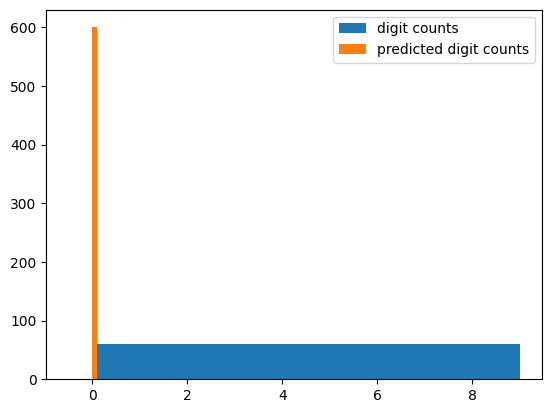

In [19]:
plt.hist(pltr(val_y), bins=10, label='digit counts')
plt.hist(yhat, bins=10, label='predicted digit counts')
plt.legend()

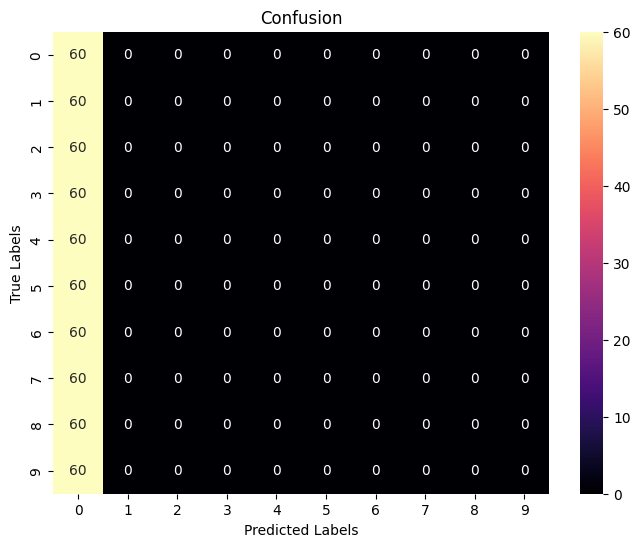

In [20]:
cm = confusion_matrix(pltr(val_y), yhat)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma', xticklabels=np.unique(pltr(val_y)), yticklabels=np.unique(pltr(val_y)))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion')
plt.show()